# EDSA Apple Prices Challenge

Imagine you are in the Fresh Produce Industry. How much stock do you have on hand? Not too little that you run out of stock when customers want to buy more. And not too much that food waste occurs. How do you set your prices? Yields from farms fluctuate by season. Should your prices then also fluctuate by season?

With this context, EDSA is challenging you to construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being able to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

## Data Overview

This dataset consists of over 60 000 sales made by [Durban Fresh Produce Market](http://www.durban.gov.za/Online_Tools/Pages/Fresh_Produce_Price_Reporting.aspx). In this notebook, we use this data to predict the average price per kilogram of Golden Delicious Apples.

Below is a brief description for each data field:
- Province - Which province the produce was grown
- Container - The code for the type of container
- Size_Grade - The class of the produce according to their quality
- Weight_Kg - The total weight in kilograms
- Commodities - The type of produce, e.g. Golden Delicious Apples
- Date - The date of the sale
- Sales_Total - The total sales price
- Total_Qty_Sold - The number of produce sold
- Total_Kg_Sold - The total weight of the produce sold in kilograms
- Stock_On_Hand - The amount of produce the store has

<h1>Table of Contents</h1>
<ul>
    <li><a href="#eda">Exploratiory Data Analysis</a></li>
    <li><a href="#modeldevelopment">Model Development</a></li>
    <li><a href="#modelevaluation">Model Selection</a></li>
    <li><a href="#modelselection">Model Selection</a></li>
</ul>

In [55]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Visualisations
import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
import numpy as np
import pandas as pd
from scipy import stats
import math
import pickle

<h1 id="edsa"> Exploratory Data Analysis   </h1>
<p>

### Basic Analysis 

In [2]:
# import the data
train = pd.read_csv('df-train_set.csv')
test = pd.read_csv('df-test_set.csv')

In [3]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64376 entries, 0 to 64375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          64376 non-null  object 
 1   Container         64376 non-null  object 
 2   Size_Grade        64376 non-null  object 
 3   Weight_Kg         64376 non-null  float64
 4   Commodities       64376 non-null  object 
 5   Date              64376 non-null  object 
 6   Low_Price         64376 non-null  float64
 7   High_Price        64376 non-null  float64
 8   Sales_Total       64376 non-null  float64
 9   Total_Qty_Sold    64376 non-null  int64  
 10  Total_Kg_Sold     64376 non-null  float64
 11  Stock_On_Hand     64376 non-null  int64  
 12  avg_price_per_kg  64376 non-null  float64
dtypes: float64(6), int64(2), object(5)
memory usage: 6.4+ MB


It's better to rename the columns to just lower case letters and underscores for convenience.

In [5]:
train.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'],
      dtype='object')

In [6]:
train.columns = ['province', 'container', 'size_grade', 'weight_kg', 'commodities',
       'date', 'low_price', 'high_price', 'sales_total', 'total_qty_sold',
       'total_kg_sold', 'stock_on_hand', 'avg_price_per_kg']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In this notebook, we only consider the average price per kg of **golden delicious** apples.

In [7]:
train = train[train['commodities'] == 'APPLE GOLDEN DELICIOUS']
train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


### Identifying and Handling Missing Values and Outliers

In [8]:
train.isnull().sum()

province            0
container           0
size_grade          0
weight_kg           0
commodities         0
date                0
low_price           0
high_price          0
sales_total         0
total_qty_sold      0
total_kg_sold       0
stock_on_hand       0
avg_price_per_kg    0
dtype: int64

### Handling Outliers

Next we examine the **kurtois** and **skew**. In general, the kurtois is a statistical measure that identifies whether the tails of a given distribution contain outliers. The skew will tell us about the skewness, that is, a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.

**High kurtosis (>3)** indicates a large number of outliers and **low kurtosis (<3)** a lack of outliers.

In [9]:
train.skew()

weight_kg           3.328254
low_price           4.222672
high_price          3.828819
sales_total         4.250317
total_qty_sold      4.445169
total_kg_sold       5.529586
stock_on_hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

In [10]:
train.kurtosis()

weight_kg            9.109698
low_price           17.073369
high_price          13.630768
sales_total         24.200524
total_qty_sold      32.338123
total_kg_sold       45.153801
stock_on_hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

In [11]:
shape_before = train.shape[0]

In [12]:
train_numerical = train.loc[:, 'weight_kg':'avg_price_per_kg'].drop(columns=['commodities','date'])
train = train[(np.abs(stats.zscore(train_numerical)) < 3).all(axis=1)]

In [13]:
print("Number of ouliers removed:", shape_before - train.shape[0])

Number of ouliers removed: 239


In [14]:
train.skew()

weight_kg           0.250577
low_price           0.678135
high_price          0.424259
sales_total         2.518151
total_qty_sold      2.075943
total_kg_sold       2.280170
stock_on_hand       2.176992
avg_price_per_kg   -0.124066
dtype: float64

In [15]:
train.kurtosis()

weight_kg          -1.068424
low_price          -0.271852
high_price         -0.827616
sales_total         7.429437
total_qty_sold      4.397705
total_kg_sold       5.872929
stock_on_hand       4.927424
avg_price_per_kg   -0.067884
dtype: float64

In [16]:
#train.reset_index(inplace=True)

train.head()

,province,container,size_grade,weight_kg,commodities,date,low_price,high_price,sales_total,total_qty_sold,total_kg_sold,stock_on_hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
80,CAPE,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-03-13,55.0,55.0,4840.0,88,792.0,181,6.11


#### Checking and Correcting the Data Format

In [17]:
train.dtypes

province             object
container            object
size_grade           object
weight_kg           float64
commodities          object
date                 object
low_price           float64
high_price          float64
sales_total         float64
total_qty_sold        int64
total_kg_sold       float64
stock_on_hand         int64
avg_price_per_kg    float64
dtype: object

As we can see, the 'Date' feature is in an incorrect format. We expect it to be in a 'datetime' format, but it is in the 'object' format.

In [18]:
train['date'] = pd.to_datetime(train['date'], format="%Y.%m.%d")
train['date'].head()

1    2020-09-09
7    2020-04-14
24   2020-04-16
40   2020-05-04
80   2020-03-13
Name: date, dtype: datetime64[ns]

In [19]:
train.dtypes

province                    object
container                   object
size_grade                  object
weight_kg                  float64
commodities                 object
date                datetime64[ns]
low_price                  float64
high_price                 float64
sales_total                float64
total_qty_sold               int64
total_kg_sold              float64
stock_on_hand                int64
avg_price_per_kg           float64
dtype: object

As we can see, the 'Date' feature is in the correct format now.

### Univariate Analysis: Non-Graphical

### Univariate Analysis: Graphical

### Multivariate Analysis: Non-Graphical 

### Multivariate Analysis: Graphical

### Descriptive Statistical Analysis

In [20]:
train.describe(include=['object'])

,province,container,size_grade,commodities
count,1713,1713,1713,1713
unique,7,10,10,1
top,CAPE,JE090,1S,APPLE GOLDEN DELICIOUS
freq,868,560,356,1713


Value counts is a good way of understanding how many units we have for each variable. **NB:** value_counts() works only on a pandas series, not a pandas DataFrame.

However, we can convert the value count series into a DataFrame using to_frame().

In [21]:
province_counts = train['province'].value_counts().to_frame()
province_counts.rename(columns={'province': 'value_counts'}, inplace=True)
province_counts

,value_counts
CAPE,868
W.CAPE-BERGRIVER ETC,416
EASTERN CAPE,203
WEST COAST,126
NATAL,81
TRANSVAAL,11
ORANGE FREE STATE,8


In [22]:
#renaming the index to province
province_counts.index.name = 'province'
province_counts.head()

,value_counts
province,
CAPE,868
W.CAPE-BERGRIVER ETC,416
EASTERN CAPE,203
WEST COAST,126
NATAL,81


In [23]:
size_counts = train['size_grade'].value_counts().to_frame()
size_counts.rename(columns={'size_grade': 'value_counts'}, inplace=True)
size_counts

,value_counts
1S,356
1M,299
2S,289
2M,227
1L,213
1X,164
2L,120
2X,26
2U,17
1U,2


In [24]:
container_counts = train['container'].value_counts().to_frame()
container_counts.rename(columns={'container': 'value_counts'}, inplace=True)
container_counts

,value_counts
JE090,560
M4183,546
EC120,397
JG110,84
EF120,74
AC030,30
M6125,10
DT063,6
EG140,3
M9125,3


As we can see from all these 3 value_count dataframes of 'province', 'size_grade' and 'container', the results are not skewed and hence the conclusion is that the 3 categorical features are reliable predictor variables of price. 

### Correlation and Causation

The p value is the evidence against a null hypothesis. The smaller the p-value, the stronger the evidence that you should reject the null hypothesis.

By convention, when the

- p-value is  <  0.001: we say there is strong evidence that the correlation is significant.
- the p-value is  <  0.05: there is moderate evidence that the correlation is significant.
- the p-value is  <  0.1: there is weak evidence that the correlation is significant.
- the p-value is  >  0.1: there is no evidence that the correlation is significant.

**Weight vs. Average Price per Kg**

In [25]:
pearson_coef, p_value = stats.pearsonr(train['weight_kg'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.4928595783675763  with a P-value of P = 1.5927942562763161e-105


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant although the linear relationship isn't extremely strong.

**Low Price vs. Average Price per Kg**

In [26]:
pearson_coef, p_value = stats.pearsonr(train['low_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.8155435142289221  with a P-value of P = 0.0


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between low price and average price per kg is statistically signifigcant and the linear relationship is quite strong.

**High Price vs. Average Price per Kg**

In [27]:
pearson_coef, p_value = stats.pearsonr(train['high_price'], train['avg_price_per_kg'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.7637014969995672  with a P-value of P = 0.0


**_Conclusion_** **:** Since the P-value is far less than 0.001, we can conclude that the p value between weight and average price per kg is statistically signifigcant and the linear relationship is strong.

### ANOVA 

Analysis of variance is a collection of statistical models and their associated estimation procedures used to analyze the differences among means of two or more groups. The ANOVA test from scipy.stats returns two results:

<p><b>F-test score</b>: ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.</p>

<p><b>P-value</b>:  P-value tells how statistically significant is our calculated score value.</p>

<p>If our price variable is strongly correlated with the variable we are analyzing, expect ANOVA to return a sizeable F-test score and a small p-value.</p>

**Provinces**

Since ANOVA analyzes the difference between different groups of the same variable, the groupby function will come in handy. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.

Let's see if different 'provinces' impact 'avg_price_per_kg.' We group the data.

In [28]:
grouped_provinces=train[['province', 'avg_price_per_kg']].groupby(['province'])
grouped_provinces.head(2)

,province,avg_price_per_kg
1,CAPE,8.51
7,CAPE,4.55
24,W.CAPE-BERGRIVER ETC,6.11
162,W.CAPE-BERGRIVER ETC,8.67
164,WEST COAST,6.15
428,EASTERN CAPE,6.74
456,NATAL,3.33
543,NATAL,3.33
732,EASTERN CAPE,8.78
1445,WEST COAST,4.44


Next we use the function 'f_oneway' in the module 'stats' to obtain the **F-test score** and **P-value**.

In [29]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_provinces.get_group('CAPE')['avg_price_per_kg'], grouped_provinces.get_group('W.CAPE-BERGRIVER ETC')['avg_price_per_kg'], 
                              grouped_provinces.get_group('WEST COAST')['avg_price_per_kg'], grouped_provinces.get_group('EASTERN CAPE')['avg_price_per_kg'],
                             grouped_provinces.get_group('NATAL')['avg_price_per_kg'], grouped_provinces.get_group('TRANSVAAL')['avg_price_per_kg'],
                             grouped_provinces.get_group('ORANGE FREE STATE')['avg_price_per_kg'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)   

ANOVA results: F= 77.15336255807766 , P = 1.9364805579772194e-85


As is turns out, this is a great result, our F-value of 77.15 indicates that the between-groups variance is over 77 times the size of the within-group variance. The null hypothesis value is that variances are equal, which produces an F-value of 1; The F-test score is showing a strong correlation and the result is almost 0 and we can infer that it's amost certain that the result is statistically significant.

**Size / Grade**

In [30]:
grouped_sizes=train[['size_grade', 'avg_price_per_kg']].groupby(['size_grade'])
grouped_sizes.head(1)

,size_grade,avg_price_per_kg
1,1L,8.51
7,2M,4.55
24,2S,6.11
40,1S,4.51
117,1M,8.33
258,1X,6.84
1265,2L,5.63
1671,2U,5.56
7521,2X,4.49
25227,1U,4.38


In [31]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_sizes.get_group('1L')['avg_price_per_kg'], grouped_sizes.get_group('2M')['avg_price_per_kg'], 
                              grouped_sizes.get_group('2S')['avg_price_per_kg'], grouped_sizes.get_group('1S')['avg_price_per_kg'],
                             grouped_sizes.get_group('1M')['avg_price_per_kg'], grouped_sizes.get_group('1X')['avg_price_per_kg'],
                              grouped_sizes.get_group('2L')['avg_price_per_kg'], grouped_sizes.get_group('2U')['avg_price_per_kg'],
                              grouped_sizes.get_group('2X')['avg_price_per_kg'], grouped_sizes.get_group('1U')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 100.58146389637793 , P = 8.894511071322435e-151


The F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001. 

**Container**

In [32]:
grouped_containers=train[['container', 'avg_price_per_kg']].groupby(['container'])
grouped_containers.head(1)

,container,avg_price_per_kg
1,M4183,8.51
7,JG110,4.55
24,JE090,6.11
117,EC120,8.33
543,AC030,3.33
1046,M6125,8.00
1391,EF120,9.38
9265,DT063,9.52
31296,M9125,5.20
34499,EG140,8.14


In [33]:
# ANOVA
f_val, p_val = stats.f_oneway(grouped_containers.get_group('M4183')['avg_price_per_kg'], grouped_containers.get_group('JG110')['avg_price_per_kg'], 
                              grouped_containers.get_group('JE090')['avg_price_per_kg'], grouped_containers.get_group('EC120')['avg_price_per_kg'],
                             grouped_containers.get_group('AC030')['avg_price_per_kg'], grouped_containers.get_group('M6125')['avg_price_per_kg'],
                              grouped_containers.get_group('EF120')['avg_price_per_kg'], grouped_containers.get_group('DT063')['avg_price_per_kg'],
                              grouped_containers.get_group('M9125')['avg_price_per_kg'], grouped_containers.get_group('EG140')['avg_price_per_kg'])
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 89.41372432191392 , P = 2.305289208431111e-136


Again, the F-test score reveals that there's a strong correlation and this is statistically significant result since the P-value << 0.001.

**We may now conlude that the useful features we can use for building machine learning models are:**

- low price
- high price 
- province 
- size_grade
- container

Feeding machine learning models with variables that meaningfully affect our target variable will improve our model's prediction variable.

<h1 id="modeldevelopment">Model Development  </h1>
<p>

### Linear Regression

In [34]:
# create a regression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

From the EDA section, we know that the good predictors are:

- low_price
- high_price
- province
- size_grade
- container

Let's develop a model using these variables as the predictor variables.

In [36]:
X = train[['low_price']]

y = train['avg_price_per_kg']

In [37]:
#fit the linear model

lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
#intercept value
lm.intercept_

3.746303751026303

In [39]:
#values of coefficients
lm.coef_

array([0.03756963])

In [40]:
Y_hat = lm.predict(X)

In [41]:
Y_hat

array([9.38174815, 5.62478522, 5.81263337, ..., 5.62478522, 4.87339263,
       7.05243113])

### Multiple Linear Regression

We in the previous section we concluded that the potentially good predictors of average price were:

- low price 
- high price

We can therefore use these predictor variables to build our models

In [42]:
Z = train[['low_price', 'high_price']]

In [43]:
# Fit the linear model using above-mentioned variables
lm.fit(Z, train['avg_price_per_kg'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [44]:
lm.intercept_

3.596103596939035

In [45]:
lm.coef_

array([0.02879873, 0.00864411])

Therefore, the linear relationship here is:

**avg_price_per_kg** = 3.596103596939035 + 0.02879873 x **low_price** + 0.00864411 x **high_price**

### Polynomial Regression

In [53]:
def PlotPolly(model, independent_variable, dependent_variabble, Name):
    '''We will use this function to plot the data'''
    x_new = np.linspace(0, 220, 400)
    y_new = model(x_new)

    plt.plot(independent_variable, dependent_variabble, '.', x_new, y_new, '-')
    plt.title('Polynomial Fit with Matplotlib for Price ~ Length')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.xlabel(Name)
    plt.ylabel('Average Price of Apples Per Kg')

    plt.show()
    plt.close()

x = train['low_price']
y = train['avg_price_per_kg']

In [47]:
# Here we use a polynomial of the 3rd order (cubic)
f = np.polyfit(x, y, 3)
p = np.poly1d(f)
print(p)

           3             2
2.048e-06 x - 0.0007968 x + 0.1255 x + 1.208


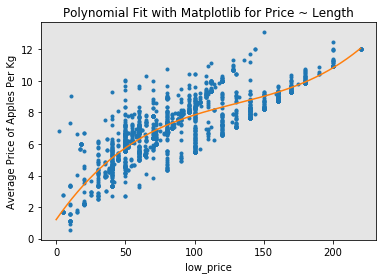

In [48]:
PlotPolly(p, x, y, 'low_price')

In [49]:
np.polyfit(x, y, 3)

array([ 2.04773072e-06, -7.96849688e-04,  1.25517070e-01,  1.20762471e+00])

In [56]:
pr=PolynomialFeatures(degree=3)
pr

PolynomialFeatures(degree=3, include_bias=True, interaction_only=False,
                   order='C')

In [57]:
Z_pr=pr.fit_transform(Z)

In [58]:
Z.shape

(1713, 2)

In [59]:
Z_pr.shape

(1713, 10)

### Pipeline

In [60]:
from sklearn.pipeline import Pipeline

In [61]:
Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(include_bias=False)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [62]:
pipe.fit(Z,y)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('polynomial',
                 PolynomialFeatures(degree=2, include_bias=False,
                                    interaction_only=False, order='C')),
                ('model',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [63]:
ypipe=pipe.predict(Z)
ypipe[0:4]

array([9.2657542 , 5.40790496, 5.68597584, 7.15605634])

### Measures For in-Sample Evaluation

**Model 1: Linear Regression**

In [64]:
# low_price fit
lm.fit(X, y)
# Find the R^2
print('The R-square is: ', lm.score(X, y))

The R-square is:  0.6651112236008601


In [65]:
# Calculate RMSE 

Yhat=lm.predict(X)
print('The output of the first four predicted value is: ', Yhat[0:4])
rmse = math.sqrt(mean_squared_error(train['avg_price_per_kg'], Yhat))
print('The root mean square error of average price per kg and the predicted value is: ', rmse)

The output of the first four predicted value is:  [9.38174815 5.62478522 5.81263337 6.7518741 ]
The root mean square error of average price per kg and the predicted value is:  1.2062557487115275


**Model 2: Mutiple Linear Regression**

In [66]:
# fit the model 
lm.fit(Z, y)
# Find the R^2
print('The R-square is: ', lm.score(Z, y))

The R-square is:  0.6764677483979282


In [67]:
Y_predict_multifit = lm.predict(Z)

In [68]:
print('The root mean square error of the average price of apples per kg and the predicted value using multifit is: ', \
      math.sqrt(mean_squared_error(train['avg_price_per_kg'], Y_predict_multifit)))

The root mean square error of the average price of apples per kg and the predicted value using multifit is:  1.1856264786555384


**Model 2: Polynomial Regression**

In [69]:
from sklearn.metrics import r2_score

In [70]:
r_squared = r2_score(y, p(x))
print('The R-square value is: ', r_squared)

rsme = math.sqrt(mean_squared_error(train['avg_price_per_kg'], p(x)))
print('The RSME value is: ', rsme)

The R-square value is:  0.7129023133580488
The RSME value is:  1.1168733964318784


<h1 id="modelevaluation">Model Evaluation  </h1>
<p>

### Training and Testing

In [71]:
y_data = train['avg_price_per_kg']
x_data = train.drop('avg_price_per_kg', axis=1)

In [72]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=1)

In [73]:
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 257
number of training samples: 1456


In [74]:
lre = LinearRegression()

In [75]:
lre.fit(x_train[['low_price']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [76]:
# R^2 on test data 
lre.score(x_test[['low_price']], y_test)

0.6620445797296447

In [77]:
# R^2 on train data 
lre.score(x_train[['low_price']], y_train)

0.6653390028279382

In [78]:
# Prediction using train data:
y_hat_train_1 = lre.predict(x_train[['low_price']])
y_hat_train_1[0:5]

array([6.00460268, 6.45430527, 8.25311563, 5.25509836, 6.37935484])

In [79]:
# Prediction using test data:
y_hat_test_1 = lre.predict(x_test[['low_price']])
y_hat_test_1[0:5]

array([ 6.00460268, 10.50162858,  5.44247444,  6.00460268,  5.25509836])

In [80]:
# RSME on training data 
train_rmse = math.sqrt(mean_squared_error(y_train, y_hat_train_1))
train_rmse

1.1912890652778827

In [81]:
#RSME on test data
test_rsme = math.sqrt(mean_squared_error(y_test, y_hat_test_1))
test_rsme

1.2878230274178561

In [84]:
#X_ = dummy_variable_df.drop('avg_price_per_kg', axis=1)
#y_ = dummy_variable_df['avg_price_per_kg']

In [85]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size = 0.15,random_state=1)

In [ ]:
#lre_dummy = LinearRegression(n_jobs=-1)

In [ ]:
# Not working, TypeError

# lre_dummy.fit(X_train, Y_train)

<h1 id="modelselection">Model Selection, Overfitting and Underfitting  </h1>
<p>

In [86]:
# Create object for multiple linear regression
lr = LinearRegression()
lr.fit(x_train[['low_price', 'high_price']], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [87]:
# Prediction using train data:
y_hat_train2 = lr.predict(x_train[['low_price', 'high_price']])
y_hat_train2[0:5]

array([5.85298646, 6.30179924, 8.09705035, 5.26799812, 6.30851359])

In [88]:
# Prediction using test data:
y_hat_test2 = lr.predict(x_test[['low_price', 'high_price']])
y_hat_test2[0:5]

array([ 5.85298646, 10.50414721,  5.41424521,  5.85298646,  5.71633876])

# Predictions

In [90]:
test.shape

(685, 13)

In [91]:
test.isnull().sum()

Index             0
Province          0
Container         0
Size_Grade        0
Weight_Kg         0
Commodities       0
Date              0
Low_Price         0
High_Price        0
Sales_Total       0
Total_Qty_Sold    0
Total_Kg_Sold     0
Stock_On_Hand     0
dtype: int64

In [92]:
#fixing the 'Date' column in the test dataset
test['Date'] = pd.to_datetime(test['Date'], format="%Y.%m.%d") 

In [93]:
X_real = pd.get_dummies(test)
X_real.head()

,Index,Weight_Kg,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Province_CAPE,...,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X,Commodities_APPLE GOLDEN DELICIOUS
0,1,12.0,2020-07-09,128.0,136.0,5008.0,38,456.0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,2,18.3,2020-01-20,220.0,220.0,1760.0,8,146.4,2,0,...,0,0,0,1,0,0,0,0,0,1
2,3,12.0,2020-08-19,120.0,120.0,720.0,6,72.0,45,0,...,0,1,0,0,0,0,0,0,0,1
3,4,18.3,2020-05-06,160.0,160.0,160.0,1,18.3,8,0,...,1,0,0,0,0,0,0,0,0,1
4,5,18.3,2020-05-04,140.0,160.0,14140.0,100,1830.0,19,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#model = LinearRegression()
#model.fit(dummy_variable_df, dummy_variable_df['avg_price_per_kg'])
#preds = model.predict(X_real)
#preds[0:5]

In [95]:
model = lm
model.fit(Z, y)
preds = model.predict(test[['Low_Price', 'High_Price']])
preds[0:5]

array([ 8.45794005, 11.83352845,  8.08924443,  9.58695804,  9.01098349])

# Submission

In [ ]:
index = df_test['Index']

In [ ]:
# create submission dataframe
submission = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': preds
    })

submission.head()

In [ ]:
# save DataFrame to csv file for submission
submission.to_csv("3rd_submission.csv", index=False)